In [253]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

data_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data_folder"))
sys.path.append(data_folder_path) 

from synth_dim_model import *
from paraparticle_utils import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import concurrent.futures
plt.rcParams.update({'font.size': 12})

np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x000002A256CADBC0> at 0x000002A206DB6580>

In [254]:
# my goal is to prepare two paraparticle states (localized paraparticles, not momentum mode paraparticles)
# this is more similarly related to VQE than it is adiabatic state prep, but my code should still apply

In [ ]:
N = 5
M = 3
V = 1

states, formatted_states = enumerate_states(N, M)

"""psi_plus_first_site = build_paraparticle_operator(N, site_index = 3, alpha = 1, sign = "+")
psi_plus_second_site = build_paraparticle_operator(N, site_index = N, alpha = 1, sign = "+")"""

H = construct_hamiltonian(N, M, V = 1, mu = 0, J = 0)
eigenvalues, eigenvectors = exact_diagonalize(H)

number_op = construct_total_paraparticle_number_operator(N)

for i, state in enumerate(eigenvectors):
    if state.conj().T @ number_op @ state == 0j:
        print(f"state {i} has zero paraparticles")
        paraparticle_vacuum = state

state 121 has zero paraparticles


In [256]:
print("paraparticle vacuum =")
for i in range(len(states)):
    print(f"{paraparticle_vacuum[i]}: {formatted_states[i]} with E = {eigenvalues[i]}")

paraparticle vacuum =
0j: |0,0,0,0,0> with E = -2.7320508075688887
0j: |0,0,0,0,1> with E = -2.732050807568884
0j: |0,0,0,0,2> with E = -2.73205080756888
0j: |0,0,0,1,0> with E = -2.7320508075688763
0j: |0,0,0,1,1> with E = -2.7320508075688745
0j: |0,0,0,1,2> with E = -2.732050807568874
0j: |0,0,0,2,0> with E = -2.7320508075688728
0j: |0,0,0,2,1> with E = -2.7320508075688728
0j: |0,0,0,2,2> with E = -2.7320508075688728
0j: |0,0,1,0,0> with E = -2.7320508075688714
0j: |0,0,1,0,1> with E = -2.7320508075688714
0j: |0,0,1,0,2> with E = -2.7320508075688634
0j: |0,0,1,1,0> with E = -1.7320508075688845
0j: |0,0,1,1,1> with E = -1.7320508075688843
0j: |0,0,1,1,2> with E = -1.7320508075688839
0j: |0,0,1,2,0> with E = -1.7320508075688834
0j: |0,0,1,2,1> with E = -1.732050807568883
0j: |0,0,1,2,2> with E = -1.7320508075688825
0j: |0,0,2,0,0> with E = -1.7320508075688807
0j: |0,0,2,0,1> with E = -1.7320508075688803
0j: |0,0,2,0,2> with E = -1.7320508075688796
0j: |0,0,2,1,0> with E = -1.7320508075

In [257]:
"""one_paraparticle_state = psi_plus_first_site @ paraparticle_vacuum
print(f"check: number of paraparticles: {one_paraparticle_state.conj().T @ number_op @ one_paraparticle_state}")
print("one paraparticle at site 1 = ")
for i in range(len(states)):
    print(f"{one_paraparticle_state[i]}: {formatted_states[i]}")"""

'one_paraparticle_state = psi_plus_first_site @ paraparticle_vacuum\nprint(f"check: number of paraparticles: {one_paraparticle_state.conj().T @ number_op @ one_paraparticle_state}")\nprint("one paraparticle at site 1 = ")\nfor i in range(len(states)):\n    print(f"{one_paraparticle_state[i]}: {formatted_states[i]}")'

In [258]:
"""two_paraparticle_state = psi_plus_second_site @ one_paraparticle_state
print(f"check: number of paraparticles: {two_paraparticle_state.conj().T @ number_op @ two_paraparticle_state}")

print("two paraparticles at site 1 and site 2 =  ")
for i in range(len(states)):
    print(f"{two_paraparticle_state[i]}: {formatted_states[i]}")"""

'two_paraparticle_state = psi_plus_second_site @ one_paraparticle_state\nprint(f"check: number of paraparticles: {two_paraparticle_state.conj().T @ number_op @ two_paraparticle_state}")\n\nprint("two paraparticles at site 1 and site 2 =  ")\nfor i in range(len(states)):\n    print(f"{two_paraparticle_state[i]}: {formatted_states[i]}")'

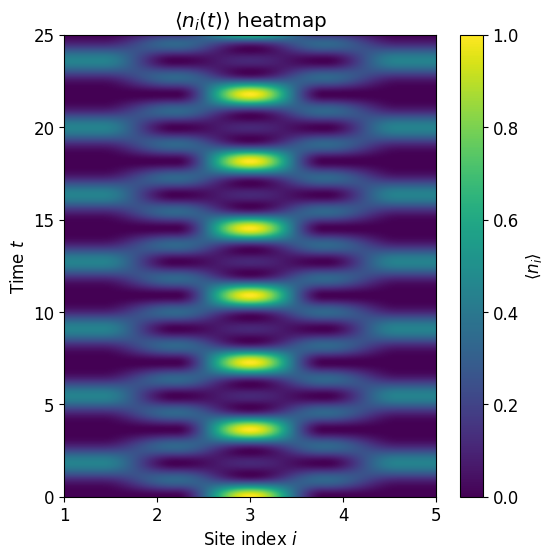

In [259]:
# first, let's look at the dynamics of a single paraparticle

times = np.linspace(0, 25, 500)

# Precompute site number operators
site_ops = [construct_site_paraparticle_number_operator(N, site_index=i+1) for i in range(N)]

# one paraparticle state

one_paraparticle_state =  build_paraparticle_operator(N, site_index = 3, alpha = 1, sign = "+") @ paraparticle_vacuum

# Time evolution
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=one_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_i(t) \rangle$ heatmap')
plt.show()


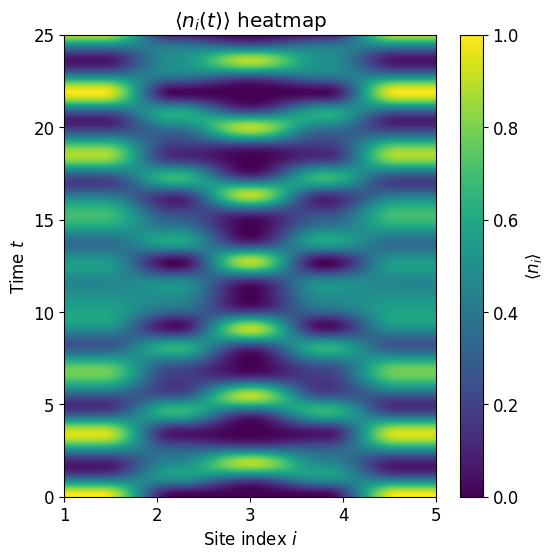

In [261]:
# now lets do it with two paraparticles

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = 5, alpha = 1, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_i(t) \rangle$ heatmap')
plt.show()


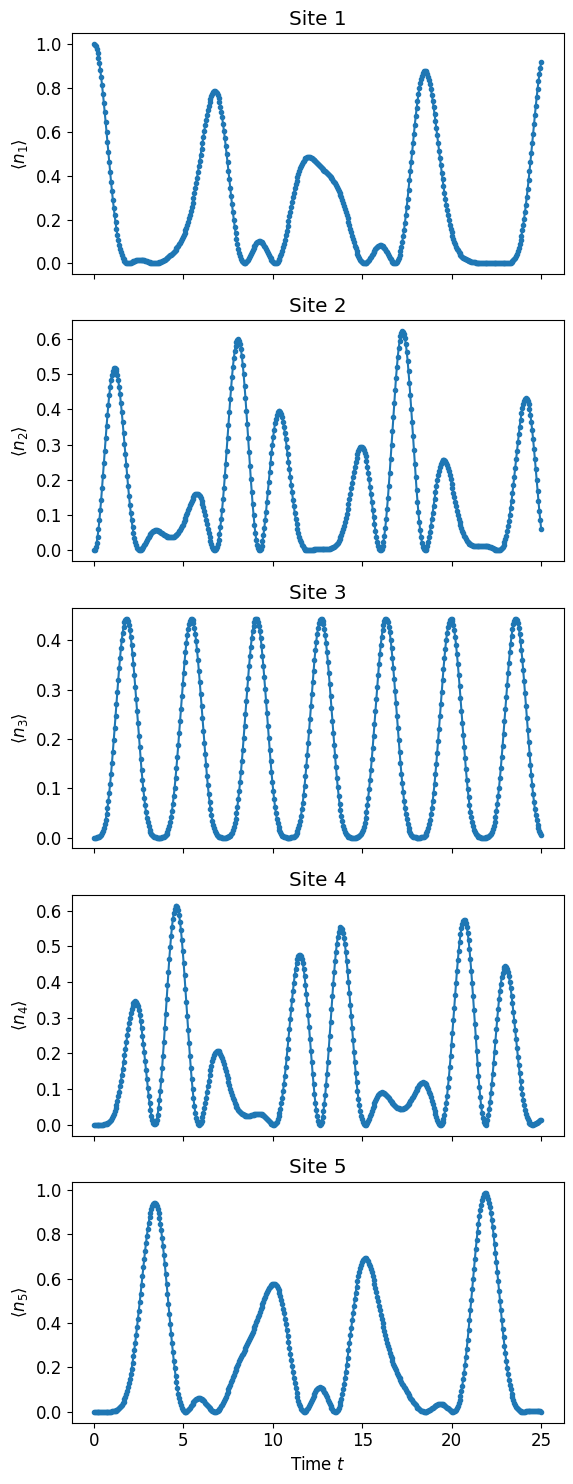

In [ ]:
"""# Evolve system
times = np.linspace(0, 25, 500)
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=one_paraparticle_state
)

# Prepare subplots
fig, axes = plt.subplots(nrows=num_sites, sharex=True, figsize=(6, 3*num_sites))

# Handle case where num_sites = 1 (axes is not a list)
if num_sites == 1:
    axes = [axes]

# Plot expectation values
for site_idx in range(num_sites):
    op = site_ops[site_idx]
    exp_values = [
        np.real(state.conj().T @ op @ state)
        for state in time_evolved_wavefunctions
    ]
    axes[site_idx].plot(times, exp_values, '.-')
    axes[site_idx].set_ylabel(rf"$\langle n_{site_idx+1} \rangle$")
    axes[site_idx].set_title(rf"Site {site_idx+1}")

axes[-1].set_xlabel(r"Time $t$")
fig.tight_layout()
plt.show()
"""